# Convert of TensorFlow Hub models to OpenVINO Intermediate Representation (IR)
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/tensorflow-hub/tensorflow-hub.ipynb) [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/eaidova/openvino_notebooks_binder.git/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fopenvinotoolkit%252Fopenvino_notebooks%26urlpath%3Dtree%252Fopenvino_notebooks%252Fnotebooks%2Ftensorflow-hub%2Ftensorflow-hub.ipynb)

This tutorial demonstrates step-by-step instructions on how to convert models loaded from TensorFlow Hub using OpenVINO Runtime.

[TensorFlow Hub](https://tfhub.dev/) is a library and online platform developed by Google that simplifies machine learning model reuse and sharing. It serves as a repository of pre-trained models, embeddings, and reusable components, allowing researchers and developers to access and integrate state-of-the-art machine learning models into their own projects with ease. TensorFlow Hub provides a diverse range of models for various tasks like image classification, text embedding, and more. It streamlines the process of incorporating these models into TensorFlow workflows, fostering collaboration and accelerating the development of AI applications. This centralized hub enhances model accessibility and promotes the rapid advancement of machine learning capabilities across the community.

You have the flexibility to run this tutorial notebook in its entirety or selectively execute specific sections, as each section operates independently.

#### Table of contents:

- [Install required packages](#Install-required-packages)
- [Image classification](#Image-classification)
    - [Import libraries](#Import-libraries)
    - [Download the classifier](#Download-the-classifier)
    - [Download a single image to try the model on](#Download-a-single-image-to-try-the-model-on)
    - [Convert model to OpenVINO IR](#Convert-model-to-OpenVINO-IR)
    - [Select inference device](#Select-inference-device)
    - [Inference](#Inference)
- [Image style transfer](#Image-style-transfer)
    - [Install required packages](#Install-required-packages)
    - [Load the model](#Load-the-model)
    - [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR)
    - [Select inference device](#Select-inference-device)
    - [Inference](#Inference)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/tensorflow-hub/tensorflow-hub.ipynb" />


## Install required packages
[back to top ⬆️](#Table-of-contents:)

In [1]:
import platform

%pip install -q pillow numpy
%pip install -q "openvino>=2023.2.0" "opencv-python"

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

%pip install -q "tensorflow-macos>=2.5; sys_platform == 'darwin' and platform_machine == 'arm64' and python_version > '3.8'" # macOS M1 and M2
%pip install -q "tensorflow>=2.5; sys_platform == 'darwin' and platform_machine != 'arm64' and python_version > '3.8'" # macOS x86
%pip install -q "tensorflow>=2.5; sys_platform != 'darwin' and python_version > '3.8'"
%pip install -q tf_keras tensorflow_hub

## Image classification
[back to top ⬆️](#Table-of-contents:)


We will use the [MobileNet_v2](https://arxiv.org/abs/1704.04861) image classification model from [TensorFlow Hub](https://tfhub.dev/).

MobileNetV2 is a compact and efficient deep learning architecture designed for mobile and embedded devices, developed by Google researchers. It builds on the success of the original MobileNet by introducing improvements in both speed and accuracy. MobileNetV2 employs a streamlined architecture with inverted residual blocks, making it highly efficient for real-time applications while minimizing computational resources. This network excels in tasks like image classification, object detection, and image segmentation, offering a balance between model size and performance. MobileNetV2 has become a popular choice for on-device AI applications, enabling faster and more efficient deep learning inference on smartphones and edge devices.

More information about model can be found on [Model page on TensorFlow Hub](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5)

### Import libraries
[back to top ⬆️](#Table-of-contents:)


In [2]:
from pathlib import Path
import os
import requests

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TFHUB_CACHE_DIR"] = str(Path("./tfhub_modules").resolve())

import tensorflow_hub as hub
import tensorflow as tf
import PIL
import numpy as np
import matplotlib.pyplot as plt

import openvino as ov

tf.get_logger().setLevel("ERROR")

In [3]:
IMAGE_SHAPE = (224, 224)
IMAGE_URL, IMAGE_PATH = (
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg",
    "data/grace_hopper.jpg",
)
MODEL_URL, MODEL_PATH = (
    "https://www.kaggle.com/models/google/mobilenet-v1/frameworks/tensorFlow2/variations/100-224-classification/versions/2",
    "models/mobilenet_v2_100_224.xml",
)

### Download the classifier
[back to top ⬆️](#Table-of-contents:)
Select a MobileNetV2 pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5) and wrap it as a Keras layer with `hub.KerasLayer`.

In [4]:
model = hub.KerasLayer(MODEL_URL, input_shape=IMAGE_SHAPE + (3,))

### Download a single image to try the model on
[back to top ⬆️](#Table-of-contents:)
The input `images` are expected to have color values in the range \[0,1\], following the [common image input conventions](https://www.tensorflow.org/hub/common_signatures/images#input). For this model, the size of the input images is fixed to `height` x `width` = 224 x 224 pixels.

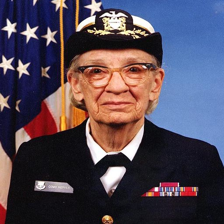

In [5]:
IMAGE_PATH = Path(IMAGE_PATH)

IMAGE_PATH.parent.mkdir(parents=True, exist_ok=True)

r = requests.get(IMAGE_URL)
with IMAGE_PATH.open("wb") as f:
    f.write(r.content)
grace_hopper = PIL.Image.open(IMAGE_PATH).resize(IMAGE_SHAPE)
grace_hopper

Normalize the image to \[0,1\] range.

In [6]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

### Convert model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)


We will convert the loaded model to OpenVINO IR using `ov.convert_model` function. We pass the model object to it, no additional arguments required. Then, we save the model to disk using `ov.save_model` function.

In [7]:
MODEL_PATH = Path(MODEL_PATH)

if not MODEL_PATH.exists():
    converted_model = ov.convert_model(model)
    ov.save_model(converted_model, MODEL_PATH)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [8]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [9]:
core = ov.Core()

compiled_model = core.compile_model(MODEL_PATH, device_name=device.value)

### Inference
[back to top ⬆️](#Table-of-contents:)


Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [10]:
output = compiled_model(grace_hopper[np.newaxis, ...])[0]
output.shape

(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `np.argmax`:

In [11]:
predicted_class = np.argmax(output[0], axis=-1)
predicted_class

653

Take the `predicted_class` ID (such as `653`) and fetch the ImageNet dataset labels to decode the predictions:

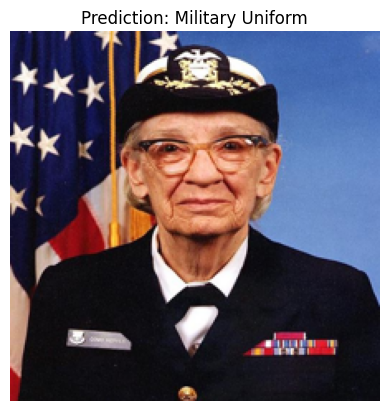

In [12]:
labels_path = tf.keras.utils.get_file(
    "ImageNetLabels.txt",
    "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt",
)
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(grace_hopper)
plt.axis("off")
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Image style transfer
[back to top ⬆️](#Table-of-contents:)

We will use [arbitrary image stylization model](https://arxiv.org/abs/1705.06830) from [TensorFlow Hub](https://tfhub.dev).

The model contains conditional instance normalization (CIN) layers 

The CIN network consists of two main components: a feature extractor and a stylization module. The feature extractor extracts a set of features from the content image. The stylization module then uses these features to generate a stylized image.

The stylization module is a stack of convolutional layers. Each convolutional layer is followed by a CIN layer. The CIN layer takes the features from the previous layer and the CIN parameters from the style image as input and produces a new set of features as output.

The output of the stylization module is a stylized image. The stylized image has the same content as the original content image, but the style has been transferred from the style image.

The CIN network is able to stylize images in real time because it is very efficient.

More model information can be found on [Model page on TensorFlow Hub](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2).

In [13]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TFHUB_CACHE_DIR"] = str(Path("./tfhub_modules").resolve())
from pathlib import Path

import openvino as ov

import tensorflow_hub as hub
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
CONTENT_IMAGE_URL = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/525babb8-1289-45f8-a3a5-e248f74dfb24"
CONTENT_IMAGE_PATH = Path("./data/YellowLabradorLooking_new.jpg")

STYLE_IMAGE_URL = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/c212233d-9a33-4979-b8f9-2a94a529026e"
STYLE_IMAGE_PATH = Path("./data/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg")

MODEL_URL = "https://www.kaggle.com/models/google/arbitrary-image-stylization-v1/frameworks/tensorFlow1/variations/256/versions/2"
MODEL_PATH = Path("./models/arbitrary-image-stylization-v1-256.xml")

### Load the model
[back to top ⬆️](#Table-of-contents:)


We load the model from TensorFlow Hub using `hub.KerasLayer`. Since the model has multiple inputs (content image and style image), we need to build it by calling with placeholders and wrap in `tf.keras.Model` function.

In [15]:
inputs = {
    "placeholder": tf.keras.layers.Input(shape=(None, None, 3)),
    "placeholder_1": tf.keras.layers.Input(shape=(None, None, 3)),
}
model = hub.KerasLayer(MODEL_URL, signature="serving_default", signature_outputs_as_dict=True)  # define the signature to allow passing inputs as a dictionary
outputs = model(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

### Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)


We convert the loaded model to OpenVINO IR using `ov.convert_model` function. We pass our model to the function, no additional arguments needed. After converting, we save the model to disk using `ov.save_model` function. 

In [16]:
if not MODEL_PATH.exists():
    MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
    converted_model = ov.convert_model(model)
    ov.save_model(converted_model, MODEL_PATH)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [17]:
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [18]:
compiled_model = core.compile_model(MODEL_PATH, device_name=device.value)

### Inference
[back to top ⬆️](#Table-of-contents:)


In [19]:
if not STYLE_IMAGE_PATH.exists():
    r = requests.get(STYLE_IMAGE_URL)
    with STYLE_IMAGE_PATH.open("wb") as f:
        f.write(r.content)
if not CONTENT_IMAGE_PATH.exists():
    r = requests.get(CONTENT_IMAGE_URL)
    with CONTENT_IMAGE_PATH.open("wb") as f:
        f.write(r.content)


def load_image(dst):
    image = cv2.imread(str(dst))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image color to RGB space
    image = image / 255  # Normalize to [0, 1] interval
    image = image.astype(np.float32)
    return image

In [20]:
content_image = load_image(CONTENT_IMAGE_PATH)
style_image = load_image(STYLE_IMAGE_PATH)
style_image = cv2.resize(style_image, (256, 256))  # model was trained on 256x256 images

In [21]:
result = compiled_model([content_image[np.newaxis, ...], style_image[np.newaxis, ...]])[0]

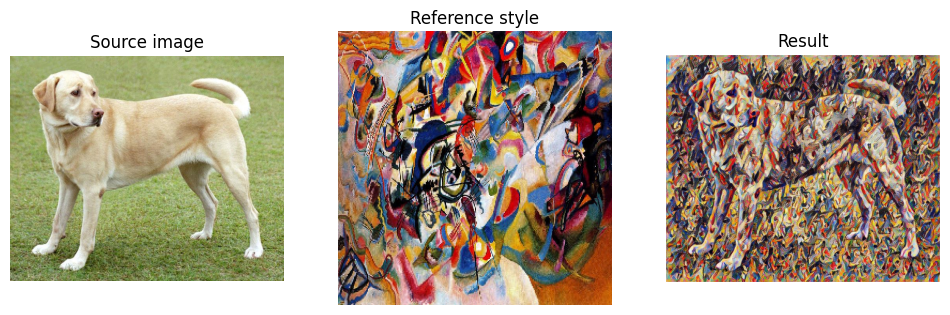

In [22]:
title2img = {
    "Source image": content_image,
    "Reference style": style_image,
    "Result": result[0],
}
plt.figure(figsize=(12, 12))
for i, (title, img) in enumerate(title2img.items()):
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title(title)
    plt.imshow(img)
    plt.axis("off")